# RNN for machine translation with a bidirectional LSTM encoder and Attention

The notebook shows how to implement a recurrent neural network for machine translation 
with help of Knet and NNHelferlein.
The net uses a Tatoeba-corpus to train a bidrirectional lstm encoder and
a lstm decoder supported by an "additive"-type attention mechanism.

The network is inspired by the Bahdanau et al. paper 
*Neural Machine Translation by Jointly Learning to Align ans Translate*, ICLR 2015.

In [1]:
#using Revise
#using Random, StatsBase
using Knet
using NNHelferlein

JOBNAME="61_RNN_bi_rnn_attn";

### The seq-2-seq-model

The sequence-to-sequence model is simple. We need
+ the type
+ a constructor
+ signatures for training (with 2 sequences as arguments) and for prediction (with only the 
  source signature as arg).

#### Type and constructor:

In [2]:
mutable struct S2S
    embed_enc       # embed layer for encoder
    embed_dec       # embed layer for decoder
    encoder         # encoder rnn
    decoder         # decoder rnn
    attn            # attention mechanism
    combine         # combine attn-context and input
    predict         # predict layer (Linear w/o actf)
    drop            # dropout layer
    voc_in; voc_out # vocab sizes
    embed           # embedding depth
    units           # number of lstm units in layers

    function S2S(n_embed, n_units, n_vocab_in, n_vocab_out)
        embed_enc = Embed(n_vocab_in, n_embed)
        drop = Dropout(0.1)
        embed_dec = Embed(n_vocab_out, n_embed)
        encoder = Recurrent(n_embed, n_units, u_type=:lstm, bidirectional=true)
        decoder = Recurrent(n_embed, 2*n_units, u_type=:lstm)
        attn = AttnBahdanau(2*n_units, 2*n_units)
        combine = Linear(2*n_units+n_embed, n_embed, actf=relu)
        predict = Linear(2*n_units, n_vocab_out)

        return new(embed_enc, embed_dec, encoder, decoder, 
            attn, combine, 
            predict, drop,
            n_vocab_in, n_vocab_out, n_embed, n_units)
    end
end

### Training signature

includes the following steps:
+ run the source sequence througth a rnn layer
+ minibatches are built from sequences of similar length - masking of input sequences 
  is not necessary.
+ transfer hidden states from encoder to decoder
+ start the decoder with the embedded target sequence with padding mask and and 
  inject attention-weighted hidden 
  states from all steps of the encoder sequence.
+ calculate and return loss with consideration of a padding mask of the target sequence
  (even if the source sequences of a minibatch are the same length, the corresponding 
  target sequences may have different lengths and need padding and masking of padded positions
  in order to ignore them in the loss calculation)



In [3]:
function (s2s::S2S)(i, o)

    seqlen_i = size(i)[1]
    seqlen_o = size(o)[1]
    i = reshape(i, seqlen_i, :)
    o = reshape(o, seqlen_o, :)
    mb = size(i)[end]
    
    o_mask = mk_padding_mask(o)
    
    x = s2s.embed_enc(i)   
    x = s2s.drop(x)
    h_enc = s2s.encoder(x, h=0, c=0, return_all=true)
    c = get_cell_states(s2s.encoder)
    h = get_hidden_states(s2s.encoder)
    
    set_cell_states!(s2s.decoder, c)
    set_hidden_states!(s2s.decoder, h)

    s2s.attn(reset=true)                   # reset projections for new minibatch
    h_enc = permutedims(h_enc, (1,3,2))    # steps last for attn
    
    y = s2s.embed_dec(o)
    h_dec = init0(s2s.decoder.n_units, 1, mb)
    
    for i in 1:seqlen_o-1
        y_i = y[:,i,:]
        c,α = s2s.attn(h, h_enc)
        
        y_i = s2s.combine(cat(y_i, c, dims=1))
        y_i = reshape(y_i, s2s.embed, 1, mb)
        
        h = s2s.decoder(y_i, return_all=false, mask=o_mask[[i+1],:])
        h = reshape(h, s2s.decoder.n_units, 1, mb)
        h_dec = cat(h_dec, h, dims=2)
    end
            
    p = s2s.predict(h_dec[:,2:end,:])
    
    t = o[2:end,:] .* convert(Array{Int32}, 1 .- o_mask[2:end,:])
    loss = nll(p,t)
    return loss
end


#### Predict signature

is very similar to the trainin signature, except of the decoder part
that now generates a step of the output sequence in every turn 
until the `<end>`-token is detected:


In [4]:
function (s2s::S2S)(i)
    
    seqlen_i, mb = size(i)
    i = reshape(i, seqlen_i, :)
    mb = size(i)[end]

    x = s2s.embed_enc(i)
    h_enc = s2s.encoder(x, h=0, c=0, return_all=true)

    h = get_hidden_states(s2s.encoder)       
    c = get_cell_states(s2s.encoder)
    set_cell_states!(s2s.decoder, c)
    set_hidden_states!(s2s.decoder, h)

    output = blowup_array([TOKEN_START], mb)
    outstep = blowup_array([TOKEN_START], mb)

    s2s.attn(reset=true)                   # reset projections for new minibatch
    h_enc = permutedims(h_enc, (1,3,2))    # steps last for attn

    MAX_LEN = 16
    step = 0
    while !all(outstep .== TOKEN_END) && step < MAX_LEN
        step += 1
        y_i = s2s.embed_dec(outstep)
        y_i = reshape(y_i, s2s.embed, mb)
        
        c,α = s2s.attn(h, h_enc)
        y_i = s2s.combine(cat(y_i, c, dims=1))
        y_i = reshape(y_i, s2s.embed, 1, mb)

        h = s2s.decoder(y_i, return_all=false)
        p = s2s.predict(h)
        y = softmax(p, dims=1)
        outstep = de_embed(y)
        output = vcat(output, outstep)
    end

    return output
end


### Training with a Tatoeba corpus:

*NNHelferlein* provides direct access to Tatoeba data. So we can train a rnn on a larger
dataset. The Tatoeba German-English corpus includes about 250000 sentences an can be 
easily accesses as follows:

In [5]:
en, de = get_tatoeba_corpus("deu")
en = en[1000:end]; de = de[1000:end];

dir = normpath(joinpath(dirname(pathof(#= /root/.julia/packages/NNHelferlein/GEtSz/src/texts.jl:314 =# @__MODULE__())), "..", "data", "Tatoeba")) = "/root/.julia/packages/NNHelferlein/GEtSz/data/Tatoeba"
pathname = joinpath(dir, fname) = "/root/.julia/packages/NNHelferlein/GEtSz/data/Tatoeba/deu-eng.zip"
Corpus for language deu is already downloaded.
Reading Tatoeba corpus for languages en-deu

importing sentences: 1000
importing sentences: 2000
importing sentences: 3000
importing sentences: 4000
importing sentences: 5000
importing sentences: 6000
importing sentences: 7000
importing sentences: 8000
importing sentences: 9000
importing sentences: 10000
importing sentences: 11000
importing sentences: 12000
importing sentences: 13000
importing sentences: 14000
importing sentences: 15000
importing sentences: 16000
importing sentences: 17000
importing sentences: 18000
importing sentences: 19000
importing sentences: 20000
importing sentences: 21000
importing sentences: 22000
importing sentenc

In [6]:
function prepare_corpus(source, target; batchsize=128, 
                        seq_len=16, vocab_size=nothing)
    source = clean_sentence.(source)
    target = clean_sentence.(target)
    
    src_vocab = WordTokenizer(source, len=vocab_size)
    trg_vocab = WordTokenizer(target, len=vocab_size)
    
    src = src_vocab(source, add_ctls=false)
    trg = trg_vocab(target, add_ctls=true)

    src = truncate_sequence.(src, seq_len, end_token=nothing)
    trg = truncate_sequence.(trg, seq_len, end_token=TOKEN_END)
    
    return sequence_minibatch(src, trg, batchsize, shuffle=true, seq2seq=true, 
                              pad=TOKEN_PAD, partial=true, x_padding=true), 
           src_vocab, trg_vocab
end 

prepare_corpus (generic function with 1 method)

In [7]:
dtato, de_vocab, en_vocab = prepare_corpus(de, en, batchsize=128, seq_len=10);

In [8]:
x1 = first(dtato)
display(x1[1])
display(x1[2])

6×128 Matrix{Int32}:
     5      5      5     5    5      5  …    887    70    70  2243    70  610
   401    778    368   778  782   1129      2583   576  2325    77   762  910
    33    217     31    26  158    810     40917   160    11     5    20  343
    12    455  11564    49  199     14       191  2576    12    27  2060  120
   399     31     67  2916    9  10860         5    26   415    33   158   18
 32242  12141    106  1384  137     26  …    725  1999   824   287  2812  253

10×128 Matrix{Int32}:
    1     1     1     1    1     1  …    1    1     1    1    1     1    1
    6     6     6     6    6     6      29   48    48   48   48    48   48
  172   275   275   275  784   972      52  322    22   22  193   193  638
   24    11    11   135   35  1023      87   16     8    8    6    14   22
    7  2283  8768  1251  213    65       7    9   280   56   44  1886  194
  200   311   874    46  191     9  …  201  269    27   16    7    22  178
    9   791     7     9    7   824     192  193  1653   14  175    23   15
 1230    23   118  1618   24   756     167    6    15  176    7    11  270
  345    35     2     2   13     2      71  112   598  699   24   459    2
    2     2     3     3    2     3       2    2     2    2    2     2    3

For the training data a single layer of 512 LSTM units and a 3 step learning-rate decay is used:

In [9]:
N_EMBED = 1024
N_UNITS = 512
s2s = S2S(N_EMBED, N_UNITS, length(de_vocab), length(en_vocab))

S2S(Embed(P(Knet.KnetArrays.KnetMatrix{Float32}(1024,40982)), identity), Embed(P(Knet.KnetArrays.KnetMatrix{Float32}(1024,19288)), identity), Recurrent(1024, 1024, :lstm, LSTM(input=1024,hidden=512,bidirectional), true), Recurrent(1024, 1024, :lstm, LSTM(input=1024,hidden=1024), true), AttnBahdanau(Linear(P(Knet.KnetArrays.KnetMatrix{Float32}(1024,1024)), K32(1024)[0.0⋯], identity), Linear(P(Knet.KnetArrays.KnetMatrix{Float32}(1024,1024)), K32(1024)[0.0⋯], identity), Linear(P(Knet.KnetArrays.KnetMatrix{Float32}(1,1024)), K32(1)[0.0⋯], identity), 0.03125, nothing), Linear(P(Knet.KnetArrays.KnetMatrix{Float32}(1024,2048)), P(Knet.KnetArrays.KnetVector{Float32}(1024)), Knet.Ops20.relu), Linear(P(Knet.KnetArrays.KnetMatrix{Float32}(19288,1024)), P(Knet.KnetArrays.KnetVector{Float32}(19288)), identity), Dropout(0.1), 40982, 19288, 1024, 512)

In [10]:
s2s = tb_train!(s2s, Adam, dtato, split=0.9, epochs=10, tb_name="$(JOBNAME)",
    acc_fun=hamming_acc, mb_loss_freq=200, eval_freq=5, eval_size=0.5,
    lr=0.001, lr_decay=0.0001, lrd_steps=3, lrd_linear=true)

Splitting dataset for training (90%) and validation (10%).
Training 10 epochs with 1746 minibatches/epoch and 194 validation mbs.
Evaluation is performed every 350 minibatches with 97 mbs.
Watch the progress with TensorBoard at:
/data/aNN/Helferlein/logs/61_RNN_bi_rnn_attn/2022-02-19T16-27-54


Progress: 100%|█████████████████████████████████████████| Time: 0:40:24m15


Setting learning rate to η=5.50e-04 in epoch 3.3
Setting learning rate to η=1.00e-04 in epoch 6.7
Training finished with:
Training loss:       0.18882979670452021
Training accuracy:   0.9084787816454619
Validation loss:     0.19574543128999852
Validation accuracy: 0.9064651601620026


S2S(Embed(P(Knet.KnetArrays.KnetMatrix{Float32}(1024,40982)), identity), Embed(P(Knet.KnetArrays.KnetMatrix{Float32}(1024,19288)), identity), Recurrent(1024, 1024, :lstm, LSTM(input=1024,hidden=512,bidirectional), true), Recurrent(1024, 1024, :lstm, LSTM(input=1024,hidden=1024), true), AttnBahdanau(Linear(P(Knet.KnetArrays.KnetMatrix{Float32}(1024,1024)), K32(1024)[0.0⋯], identity), Linear(P(Knet.KnetArrays.KnetMatrix{Float32}(1024,1024)), K32(1024)[0.0⋯], identity), Linear(P(Knet.KnetArrays.KnetMatrix{Float32}(1,1024)), K32(1)[0.0⋯], identity), 0.03125, K32(1024,128,7)[3.2399335⋯]), Linear(P(Knet.KnetArrays.KnetMatrix{Float32}(1024,2048)), P(Knet.KnetArrays.KnetVector{Float32}(1024)), Knet.Ops20.relu), Linear(P(Knet.KnetArrays.KnetMatrix{Float32}(19288,1024)), P(Knet.KnetArrays.KnetVector{Float32}(19288)), identity), Dropout(0.1), 40982, 19288, 1024, 512)

Tensorboard output:

<img src="assets/61-rnn-acc.png">

Loss: <img src="assets/61-rnn-loss.png">

### Translation:

A last signature allows us to directly translate a sentence from German to English:

In [12]:
function translate(inp::T; mdl=s2s, sv=de_vocab, tv=en_vocab) where {T <: AbstractString}
    
    in_seq = sv(inp, split_words=true, add_ctls=false)
    in_seq = reshape(in_seq, (:,1))
    out_seq = mdl(in_seq)
    return tv(out_seq)
end
    

translate (generic function with 1 method)

In [13]:
translate("Tom hört gewöhnlich klassische Musik")

"<start> Tom usually listens to classical music <end>"

In [14]:
translate("Tom trägt fast immer dunkle Kleidung")

"<start> Tom almost always wears dark clothes <end>"

In [15]:
translate("Wie viel Bier soll ich kaufen?")

"<start> How much beer should I buy <end>"

In [16]:
translate("Ich brauche eine Mütze voll Schlaf")

"<start> I need to get some shut-eye <end>"

In [17]:
translate("Ich muss mehr Kaffee trinken")

"<start> I need to drink more coffee <end>"

In [18]:
translate("Tom muss mehr Kaffee trinken")

"<start> Tom needs to drink more coffee <end>"

### Attention factors visualised:

The predict signature can be modified to return attention factors instead of the 
output sequence.
The fun `show_attn` displays the attention factors for a translation as heatmap. Light colours show
to which encoder positions the decoder gives high attention  in each sequence generation step:

In [19]:
using Plots
function show_attn(sentence::T; mdl=s2s, sv=de_vocab, tv=en_vocab) where {T <: AbstractString}

    in_seq = sv(sentence, split_words=true, add_ctls=false)
    in_seq = reshape(in_seq, :,1)
    out_seq = mdl(in_seq)
    o = tv(out_seq)

    # get alphas:
    #
    seqlen_i = size(in_seq)[1]
    seqlen_o = size(out_seq)[1]
    in_seq = reshape(in_seq, seqlen_i, :)
    out_seq = reshape(out_seq, seqlen_o, :)
    mb = 1
    
    x = mdl.embed_enc(in_seq)   
    h_enc = mdl.encoder(x, h=0, c=0, return_all=true)
    c = get_cell_states(mdl.encoder)
    h = get_hidden_states(mdl.encoder)
    
    set_cell_states!(mdl.decoder, c)
    set_hidden_states!(mdl.decoder, h)

    s2s.attn(reset=true)                   # reset projections for new minibatch
    h_enc = permutedims(h_enc, (1,3,2))    # steps last for attn
    
    y = mdl.embed_dec(out_seq)
    alpha = init0(seqlen_i, seqlen_o)
    
    for i in 1:seqlen_o-1
        y_i = y[:,i,:]
        c,α = s2s.attn(h, h_enc)
        
        y_i = s2s.combine(cat(y_i, c, dims=1))
        y_i = reshape(y_i, s2s.embed, 1, mb)
        
        h = s2s.decoder(y_i, return_all=false)
        h = reshape(h, s2s.decoder.n_units, 1, mb)
        alpha[:,i] = α
    end
    alpha = Array(alpha)
            
    # visualise:
    #
    i_words = split(sentence)
    o_words = split(o)[2:end]
    heatmap(alpha, xrotation=45,
            yticks=(1:length(i_words), i_words), 
            xticks=(1:length(o_words), o_words))
    end


show_attn (generic function with 1 method)

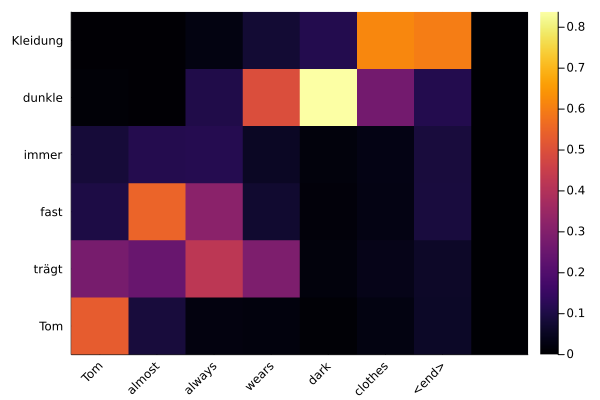

In [20]:
show_attn("Tom trägt fast immer dunkle Kleidung")

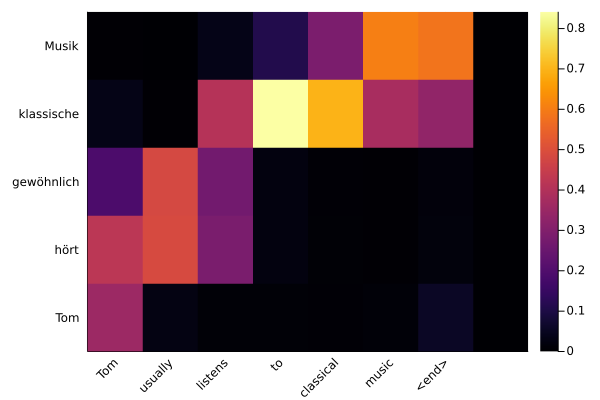

In [21]:
show_attn("Tom hört gewöhnlich klassische Musik")

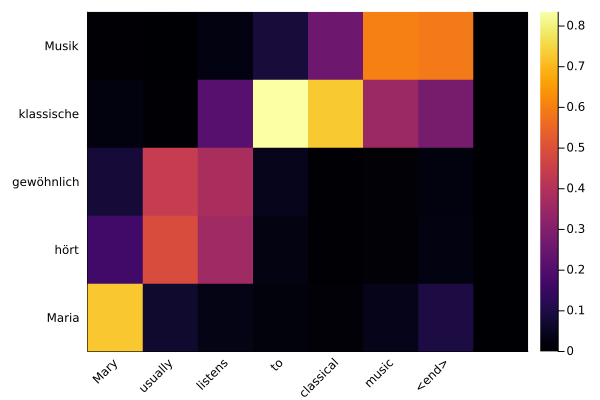

In [22]:
show_attn("Maria hört gewöhnlich klassische Musik")

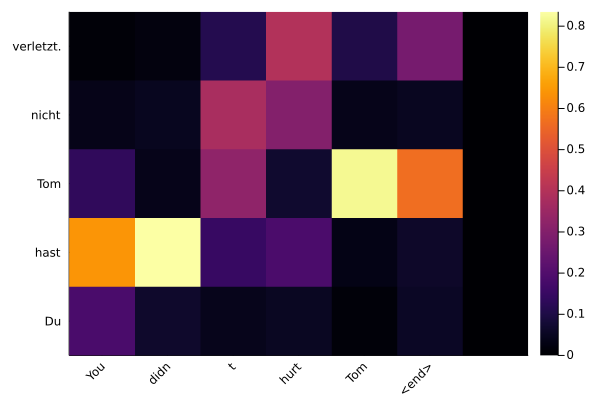

In [23]:
show_attn("Du hast Tom nicht verletzt.")

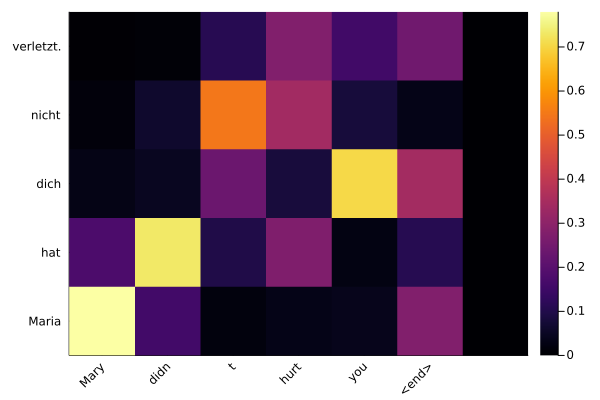

In [24]:
show_attn("Maria hat dich nicht verletzt.")

The examples show the ability of the attention mechanism to correlate words at different positions of 
source and target sequence (the last German word *verletzt* corresponds with the 5th word *hurt* in the english sentence; the 3rd German word *dich* corresponds with the last English word *you*: the 
attention displays that the model has learned these rules.

The last sentences are not part of the training - the attention mechanism makes it possible to 
replace words of a sentence and insert their translation at the correct location of the output sequence
(here *You* -> *Mary* and *Tom* -> *you*).